In [6]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import importlib
from modules import base_model as bm 
from modules import obstacles as obs
from modules import run_simulation
from modules import attractor as att
#from modules import attract

importlib.reload(bm); importlib.reload(obs); importlib.reload(run_simulation); importlib.reload(att)

print(f'Imported modules successfully!')

Imported modules successfully!


**Attractor** \
We are considering adding a global attractor for 2 reasons. 
1. Migratory patterns are realistic. Currently initialisation and then flocking are the only deciders in where the birds go. It is more relaistic that the are heading towards something.
Birds aren't generally out for a leisurely stroll I assume. 
2. Currently when a bird hits an obstacle they 'bounce back' and go the opposite way. This isn't realistic. Birds should veer around the object. We think that if there is a global attractor which is strong enough, the birds will be forced to veer due to this attraction. I hope. \

There seems to be 2 types of attractors I can find.
1. Follow the leader. Birds follow a $p_l$ leader. However, I don't think this is what we want. We want a specific attractor.
2. Mouse. For example (https://medium.com/@issacroy05/boids-simulating-flocks-e11c121a35cc), birds see a mouse and go towards that. Hopefully we can extend this from a position to a range, or have the position be much further away.


In [5]:
# IDENTICAL to that in toy_problem.ipynb.
# v0, eta, L, dt, Nt, N.
model_params = [0.3, 0.6, 10, 0.2, 200, 100]

# lam_c, lam_a, lam_m, lam_att, A, R.
strength_params = [0.2, 0.8, 0.4, 0.2, 0.15, 1.25]

# obstacle_params = [lam_o, x_obs, y_obs, O]
obstacle_params = [[2, 5, 5, 1.5], [1, 2, 8, 1.5], [1, 8, 2, 1.5]]

**Changes** \
See the file `attractor.py`. Similar to what Fred did, I have added a python file which shows the code for the attractor 'rule'.
This is like the previous rules, it returns a velocity. This velocity is added to the position with the other rules at each step.
I have updated the step function to include this. Docstrings and comments explain the code and changes. 

Main thoughts: 
1. Attractor does not have to be in the grid, say 10x10. It can be at (x, y) = (30, 30) for example. I need to test, but I assume if it's very far away it would act like migration and look as though the birds are going towards an area rather than a single point. 
2. If the strength is high ($\lambda_{att}$), it overwrites the obstacle propulsion and just cuts straight through. Obviously a big issue. Keep factor below ~0.2.

I have also played around with the initialisation of birds. We can have them start in a specified area, as I have done. Code can obviously be improved to include it as an input argument.
My codespace is making it very hard to make changes with module errors.

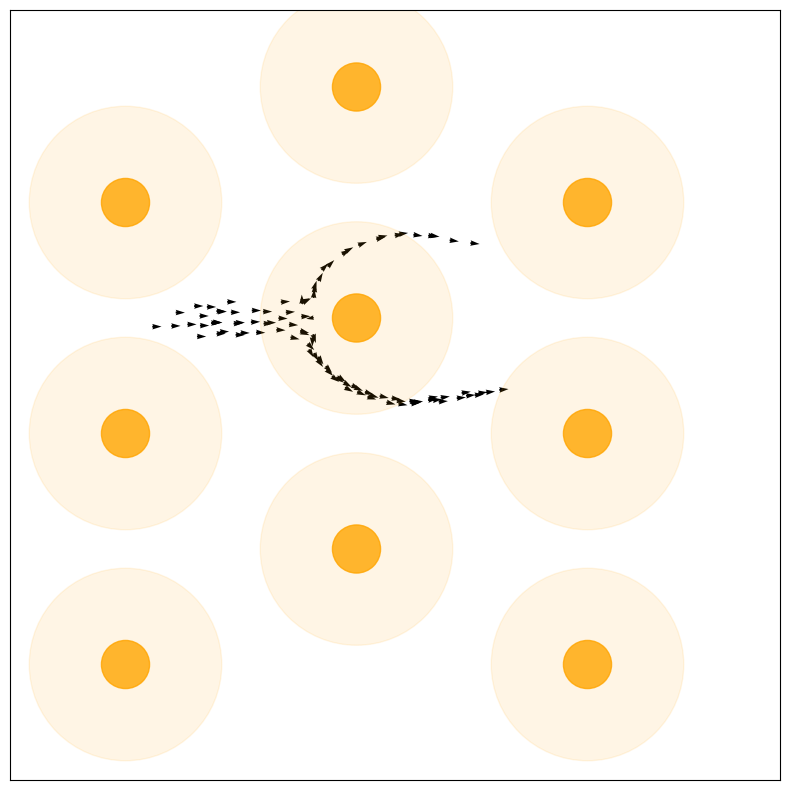

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [6]:
# As many obstacle params as we can without overlapping
lam_o = 1
O_rad = 1.25

obstacle_params = [
 [lam_o, 1.5, 1.5, O_rad],
 [lam_o, 1.5, 4.5, O_rad],
 [lam_o, 1.5, 7.5, O_rad],

 [lam_o, 4.5, 3.0, O_rad],
 [lam_o, 4.5, 6.0, O_rad],
 [lam_o, 4.5, 9.0, O_rad],

 [lam_o, 7.5, 1.5, O_rad],
 [lam_o, 7.5, 4.5, O_rad],
 [lam_o, 7.5, 7.5, O_rad]
]

run_simulation.plot_simulation_att(model_params, strength_params, obstacle_params, [15, 6])

We want to try add a global attractor

### Notes for Colm, from Fred
Have changed the initialisation in `base_model.py` to depend on $L$ again. By default it now initialises birds within the bottom-left quadrant $(L/4)$.

Have changed all functions to now depend on obstacles as a list of obstacle parameters (a list of lists). If it's just one obstacle, you should still be able to pass it just one single list. 

Changed the plotting function very slightly by adding `add_obstacle()`, feel free (anyone) to change the way the obstacles look.

**Conerns.** This was suggested by Reynolds in the first place and is a big reason we will (possibly) use 'steer-to-avoid'; currently, if the birds approach an obstacle at a direct angle, they will not alter their velocity until very late. You can see this in the simulation above towards the end. That being said, if they aren't coming at it completely straight, it works really well.

Is `attract.py` redundant now or is it there for some other reason?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import importlib
from modules import base_model as bm 
from modules import obstacles as obs
from modules import run_simulation
from modules import attractor as att
from modules import Testing as test


importlib.reload(bm); importlib.reload(obs); importlib.reload(run_simulation); importlib.reload(att); importlib.reload(test)

print(f'Imported modules successfully!')

Imported modules successfully!


**Time Testing** \
See the three functions in `Testing.py`. \
Initial loop is the time taken for the birds to reach an x position. i.e we set x to 10. If they pass 10 then they are removed. Count the number of steps for all birds to cross or for the loop to finish all of its iterations. \
mean_step() runs this N times and returns an average of the time taken and a success rate. success rate is the percentage of birds to make it before the loop breaks. This will be useful if we implement killing or a more robust simulation where they may not make it to the end. \
mean_time() takes the various configurations and iterats through them applying the above function. The results are printed in a simple table.

The results show a difference, but it's quite minimal. I'll have to play around with parameters a bit. I think the location of the attractor could have an effect on the various results of configs. I also think a more robust grid would be useful. I.e try it on an L = 50 with loads of obstacles

In [7]:
# IDENTICAL to that in toy_problem.ipynb.
# v0, eta, L, dt, Nt, N.
model_params = [0.3, 0.6, 10, 0.2, 200, 100]

# lam_c, lam_a, lam_m, lam_att, A, R.
strength_params = [0.2, 0.8, 0.4, 0.2, 0.15, 1.25]

attractor_pos = [15,5] #[x, y] position of global attractor. Migration destination
goal = 9 #Goal boundary. A vertical line at x = 9 for example
obs_method = 'forcefield' #Obstacle method: 'forcefield' or 'steer2avoid'
iters = 10 #Number of loops to get average time and success rate at each configuration

configs = [
    #Our basis: No Obstacles
    [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
    # Linear barrier patterns
    [[1, 2, 5, 1], [1, 4, 5, 1], [1, 6, 5, 1]],  # Horizontal line
    [[1, 5, 2, 1], [1, 5, 5, 1], [1, 5, 8, 1]],  # Vertical line
    
    # Diagonal patterns
    [[1, 2, 2, 1], [1, 5, 5, 1], [1, 8, 8, 1]],  # Main diagonal
    [[1, 8, 2, 1], [1, 5, 5, 1], [1, 2, 8, 1]],  # Anti-diagonal
    
    # Corner protection
    [[1, 1, 1, 1], [1, 1, 9, 1], [1, 9, 1, 1]],  # Three corners
    [[1, 9, 9, 1], [1, 1, 9, 1], [1, 9, 1, 1]],  # All corners
    
    # Central clustering
    [[1, 4, 4, 1], [1, 5, 5, 1], [1, 6, 6, 1]],  # Tight cluster
    [[1, 3, 3, 1], [1, 5, 7, 1], [1, 7, 3, 1]],  # Spread but balanced
]

key = [
    "No Obstacles",
    "Horizontal line",
    "Vertical line",
    "Main diagonal",
    "Anti-diagonal",
    "Three corners",
    "All corners",
    "Tight cluster",
    "Spread but balanced"
]

test. mean_times(model_params, strength_params, configs, obs_method, attractor_pos, goal, iters, key, seed = None)




| Configuration        | Average Time    | Success Rate    |
| -------------------- | --------------- | --------------- |
| No Obstacles         | 78.80           | 100.00          |
| Horizontal line      | 79.10           | 100.00          |
| Vertical line        | 80.70           | 100.00          |
| Main diagonal        | 80.00           | 100.00          |
| Anti-diagonal        | 79.20           | 100.00          |
| Three corners        | 80.00           | 100.00          |
| All corners          | 79.20           | 100.00          |
| Tight cluster        | 82.10           | 100.00          |
| Spread but balanced  | 80.50           | 100.00          |
